## Funder network data
This notebook goes through the steps of processing, generating, analyzing, and visualizing data around the funder ecosystem that the Robert Sterling Clark Foundation is a part of. The purpose is to better understand the ecosystem, how it is evolving over time, and provide information to grantee partners about the wider ecosystem and its players.

We used a combination of data available via the Impala database and IRS Form 990 data available via the [ProPublica Nonprofit Explorer API](https://projects.propublica.org/nonprofits/api). We use data from Impala to obtain the most recent IRS data, and data from ProPublica to obtain historical data, as the database hadn't been updated.

Because Impala's database is not publicly available, we won't provide the associated data to reproduce this example notebook. Data should be placed in a data/ directory and referenced as such throughout.

Requirements:
- Install the necessary packages using your chosen package manager. We provide a simple requirements.txt
- An OpenAI API key, which can be obtained from 

In [86]:
# Import requirements
import requests
import fuzzywuzzy
import pandas as pd
from rapidfuzz import process, fuzz
from matplotlib import pyplot as plt
import numpy as np
import squarify
import textwrap
import xml.etree.ElementTree as ET
import os
import zipfile
from openai import OpenAI
from pydantic import BaseModel
from dotenv import load_dotenv
import math

load_dotenv() # Load API key(s)
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")


In [3]:
# UTILITIES
def convert_money_string(s):
    if pd.isna(s):
        return None
    s = s.replace('$', '').strip()
    if s.endswith('M'):
        return int(float(s[:-1]) * 1_000_000)
    elif s.endswith('K'):
        return int(float(s[:-1]) * 1_000)
    elif s.endswith('B'):
        return int(float(s[:-1]) * 1_000_000_000)
    else:
        return int(float(s))  # in case it's just a number without suffix


### Import funder network data from Impala
Here we import funders which also fund grantee-partners of the Robert Sterling Clark Foundation from the Impala database, but this could be a replaced by any dataset of funders of interest.

We use two separate datasets - one manually aggregated, curated list, and one list auto-generated by the Impala database, which shows funders who share grantee-partners with RSCF.

We will use the combined datasets for metadata generation. Overlap analysis is enabled by the auto-generated list, so only funders in the Impala generated list will appear in that visualization.

In [40]:
# Manually aggregated, reviewed list
reviewed_nyc_funder_data = pd.read_excel("data/RSCF_NYC_FUNDERS.xlsx")[['Funder', 'Location', 'State', 'Total Assets', 'Operating Budget',
       'Contributions Given', 'Median Grant Given', 'Contributions Received',
       'Funders', 'Total Staff']] # Read in if needed
print(f"Reviewed funders: {len(reviewed_nyc_funder_data)}")
reviewed_nyc_funder_data.head()

Reviewed funders: 83


,Funder,Location,State,Total Assets,Operating Budget,Contributions Given,Median Grant Given,Contributions Received,Funders,Total Staff
0,ALAN & HOPE WINTERS FAMILY FOUNDATION,NEW YORK,NY,0.0,30900.0,5700000.0,5000.0,NaN,-,0
1,THE A WOODNER FUND INC,NEW YORK,NY,3800.0,3600.0,660000.0,8000.0,NaN,-,0
2,THE RUDIN FOUNDATION INC,NEW YORK,NY,8500.0,11700.0,NaN,NaN,NaN,-,20
3,MAY AND SAMUEL RUDIN FAMILY FOUNDATION INC,NEW YORK,NY,75200.0,309600.0,4500000.0,10000.0,NaN,-,11
4,SHELLEY & DONALD RUBIN FOUNDATION,NEW YORK,NY,218200.0,577800.0,NaN,NaN,NaN,-,4


In [ ]:
# Impala generated list
# Import funders with overlapping grantee-partners
impala_cofunders = pd.read_csv('data/overlapping_funders.csv').drop(columns = "#")
impala_cofunders['Co-Funder'] = impala_cofunders['Co-Funder'].str.split('\n').str[0]
impala_cofunders = impala_cofunders[impala_cofunders["Funded Nonprofits"] > 4] # For these purposes, drop any funders with 4 or less overlapping grantee partners

# Apply to the column
impala_cofunders['Combined Funding'] = impala_cofunders['Combined Funding'].apply(convert_money_string)

# Display first few rows
print(f"Impala co-funders: {len(impala_cofunders)}")
impala_cofunders.head()

Impala co-funders: 207


,Co-Funder,Funded Nonprofits,Combined Funding
0,THE FORD FOUNDATION,42,87700000
1,Amalgamated Charitable Foundation Inc,32,29700000
2,Rockefeller Philanthropy Advisors Inc,28,29500000
3,WELLSPRING PHILANTHROPIC FUND INC,26,31200000
4,NEW YORK WOMEN'S FOUNDATION INC,25,3900000


In [46]:
# Combined datasets
reviewed_nyc_funder_data = reviewed_nyc_funder_data.rename(columns = {"Funder": "Co-Funder"})
cofunders = pd.merge(reviewed_nyc_funder_data, impala_cofunders, how="outer", on="Co-Funder")
print(f"Combined funders: {len(cofunders)}")
cofunders.head()

Combined funders: 269


,Co-Funder,Location,State,Total Assets,Operating Budget,Contributions Given,Median Grant Given,Contributions Received,Funders,Total Staff,Funded Nonprofits,Combined Funding
0,AARP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,349000.0
1,ABNY FOUNDATION INC,NEW YORK,NY,2100000.0,215700.0,200000.0,10000.0,129000.0,4,1,NaN,NaN
2,ALAN & HOPE WINTERS FAMILY FOUNDATION,NEW YORK,NY,0.0,30900.0,5700000.0,5000.0,NaN,-,0,NaN,NaN
3,ALFRED P SLOAN FOUNDATION,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,5000000.0
4,ALTMAN FOUNDATION,NEW YORK,NY,283300000.0,6500000.0,12600000.0,50000.0,NaN,-,13,12.0,4200000.0


### Get organization data
We use LLMs to search the web to enrich the information we have available. Specifically, we are looking for a geographic focus (NYC) and for a programmatic focus on leadership development. We also check for whether or not they accept unsolicited proposals.

In [47]:
from openai import OpenAI
from pydantic import BaseModel

# Define the structured output model
class FunderMetadata(BaseModel):
    geo_focus: str
    geo_focus_citation: list[str]
    lead_dev_focus: bool
    lead_dev_citation: list[str]
    accept_loi: bool
    accept_loi_citation: list[str]

def research_funder(funder: str) -> FunderMetadata:
    """
    Use OpenAI web search to identify a funder's geographic and programmatic areas of focus,
    and whether they accept unsolicited proposals (LOIs).
    """
    client = OpenAI(api_key=OPENAI_API_KEY)

    response = client.responses.parse(
        model="gpt-4o-mini-2024-07-18",
        tools=[{"type": "web_search"}],
        text_format=FunderMetadata,  
        input=[
            {
                "role": "system",
                "content": (
                    "You are a research assistant that identifies information about philanthropic organizations "
                    "from trusted web sources such as official websites, GuideStar, and ProPublica. "
                    "You should prioritize official and reputable data sources, specifically the organization's own website and communications."
                ),
            },
            {
                "role": "user",
                "content": f"""
                Find the following information for the organization "{funder}":
                - Geographic area(s) of grantmaking focus. 
                - Whether they have a focus on leadership development or civic engagement
                - Whether they accept letters of interest (LOIs) or unsolicited proposals
                - For each of these, provide the URL or URLs that you sourced this information from

                Return the information as a JSON object with the following fields:
                {{
                    "geo_focus": "<geographic area(s)>",
                    "geo_focus_citation": [url1]
                    "lead_dev_focus": <true/false>,
                    "lead_dev_citation": [url1, url2]
                    "accept_loi": <true/false>,
                    "accept_loi_citation": [url1]
                }}
                """
            }
        ]
    )

    # The structured response will be parsed directly into the model
    return response.output_parsed


In [49]:
def enrich_cofunder_metadata(cofunders: pd.DataFrame) -> pd.DataFrame:
    # Initialize empty lists to store results
    geo_focus_list = []
    lead_dev_focus_list = []
    accept_loi_list = []

    for funder in cofunders["Co-Funder"]:
        print(f"Processing {funder}")
        try:
            metadata = research_funder(funder)

            # Access attributes from the Pydantic model
            geo_focus_list.append(metadata.geo_focus)
            lead_dev_focus_list.append(metadata.lead_dev_focus)
            accept_loi_list.append(metadata.accept_loi)
            
        except Exception as e:
            print(f"Error processing {funder}: {e}")
            geo_focus_list.append(None)
            lead_dev_focus_list.append(None)
            accept_loi_list.append(None)

    # Add new columns to the DataFrame
    cofunders["geo_focus"] = geo_focus_list
    cofunders["lead_dev_focus"] = lead_dev_focus_list
    cofunders["accept_loi"] = accept_loi_list

    return cofunders

cofunders = enrich_cofunder_metadata(cofunders)
print(cofunders.head())


Processing AARP
Processing ABNY FOUNDATION INC
Processing ALAN & HOPE WINTERS FAMILY FOUNDATION
Processing ALFRED P SLOAN FOUNDATION
Processing ALTMAN FOUNDATION
Processing AMERICAN COUNCIL OF LEARNED SOCIETIES
Processing AMERICAN EXPRESS FOUNDATION
Processing ARC OF JUSTICE
Processing ARCUS FOUNDATION
Processing ARIE AND IDA CROWN MEMORIAL
Processing Amalgamated Charitable Foundation Inc
Processing Annie E Casey Foundation Inc
Processing BAIRD FOUNDATION INC
Processing BEN & JERRY'S FOUNDATION INC
Processing BERNARD AND ANNE SPITZER CHARITABLE TRUST
Processing BILL & MELINDA GATES FOUNDATION
Processing BLUE MERIDIAN PARTNERS INC
Processing BOOTH FERRIS FOUNDATION XXXXX4008
Processing BOREALIS PHILANTHROPY
Processing BREAD AND ROSES COMMUNITY FUND
Processing BROOKLYN COMMUNITY FOUNDATION
Processing Barr Foundation
Processing Boston Foundation, Inc
Processing CALIFORNIA COMMUNITY FOUNDATION
Processing CALIFORNIA HEALTHCARE FOUNDATION
Processing CALIFORNIA PHYSICIANS' SERVICE FDN DBA BLU

In [50]:
# Create NYC focus filter
contains_nyc_or_manhattan = cofunders['nyc_focus'] = cofunders['geo_focus'].str.contains(r'\b(NYC|Manhattan|Bronx|Queens|Brooklyn|Staten Island|New York City)\b', case=False, na=False)

# Create national focus filter
contains_national = cofunders['geo_focus'].str.contains(r'\b(national|United States|US)\b', case=False, na=False)

cofunders['nyc_focus'] = np.where(contains_nyc_or_manhattan, True, False) #  & ~contains_national
cofunders['national_focus'] = contains_national
cofunders.head()

C:\Users\laura\AppData\Local\Temp\ipykernel_25572\168274753.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  contains_nyc_or_manhattan = cofunders['nyc_focus'] = cofunders['geo_focus'].str.contains(r'\b(NYC|Manhattan|Bronx|Queens|Brooklyn|Staten Island|New York City)\b', case=False, na=False)
C:\Users\laura\AppData\Local\Temp\ipykernel_25572\168274753.py:5: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  contains_national = cofunders['geo_focus'].str.contains(r'\b(national|United States|US)\b', case=False, na=False)


,Co-Funder,Location,State,Total Assets,Operating Budget,Contributions Given,Median Grant Given,Contributions Received,Funders,Total Staff,Funded Nonprofits,Combined Funding,geo_focus,lead_dev_focus,accept_loi,nyc_focus,national_focus
0,AARP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,349000.0,"United States, Puerto Rico, U.S. Virgin Islands",True,False,False,True
1,ABNY FOUNDATION INC,NEW YORK,NY,2100000.0,215700.0,200000.0,10000.0,129000.0,4,1,NaN,NaN,"New York City, United States",True,True,True,True
2,ALAN & HOPE WINTERS FAMILY FOUNDATION,NEW YORK,NY,0.0,30900.0,5700000.0,5000.0,NaN,-,0,NaN,NaN,Information not available,False,False,False,False
3,ALFRED P SLOAN FOUNDATION,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,5000000.0,United States,False,True,False,True
4,ALTMAN FOUNDATION,NEW YORK,NY,283300000.0,6500000.0,12600000.0,50000.0,NaN,-,13,12.0,4200000.0,New York City,False,True,True,False


In [51]:
# Optionally save CSV at this step
cofunders.to_csv("data/RSCF_OVERLAPPING_FUNDERS.csv")

In [52]:
# Get only NYC overlapping funders
ny_cofunders = cofunders[cofunders["nyc_focus"] == True]

In [119]:
# Get only those in the manual dataset
reviewed_nyc_funder_data_enriched = ny_cofunders[~ny_cofunders["Location"].isna()]
reviewed_nyc_funder_data_enriched.shape

(15, 17)

#### Create treemap visualization of grantee-partner overlap with other funders and the Foundation 


C:\Users\laura\AppData\Local\Temp\ipykernel_25572\3378786939.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ny_cofunders["Funded Nonprofits"] = ny_cofunders["Funded Nonprofits"].astype(int)


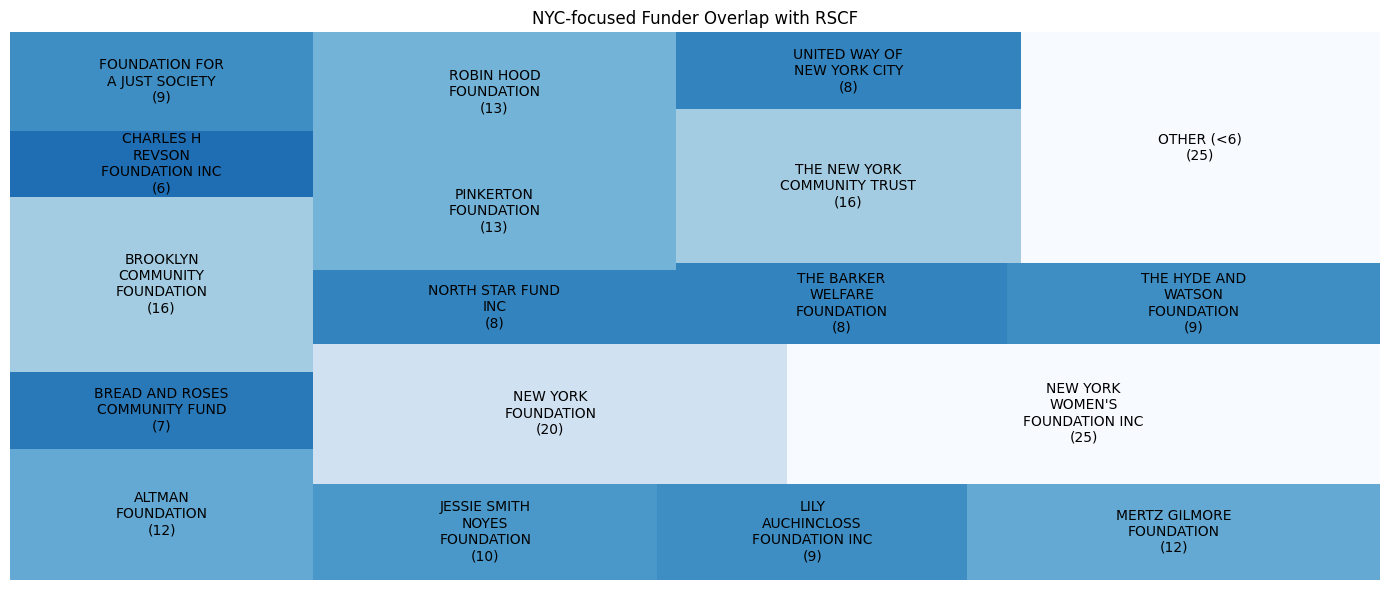

In [57]:

# Create a mask for overlap of 5 or less nonprofits, based on substantial overlapping grantees
ny_cofunders["Funded Nonprofits"] = ny_cofunders["Funded Nonprofits"].astype(int)
ny_cofunders = ny_cofunders[~ny_cofunders["Funded Nonprofits"].isna()] # Drop out those that were only in the manually curated dataset
mask = ny_cofunders["Funded Nonprofits"] < 6

# Sum up all below-5 values
other_sum = ny_cofunders.loc[mask, "Funded Nonprofits"].sum()

# Keep only rows >= 5
df_filtered = ny_cofunders.loc[~mask].copy()
other_row = pd.DataFrame({
    "Co-Funder": ["Other (<6)"],
    "Funded Nonprofits": [other_sum]
})

# Append "Other" row
df_filtered = pd.concat([df_filtered, other_row], ignore_index=True)
df_filtered["Co-Funder"] = df_filtered["Co-Funder"].apply(lambda x: x.upper())

# Plot treemaps
fig, axes = plt.subplots(figsize=(14, 6))

def wrap_label(name, value, width=15):
    wrapped_name = "\n".join(textwrap.wrap(name, width=width))
    return f"{wrapped_name}\n({value})"

# Create wrapped labels with values
labels = [
    wrap_label(row["Co-Funder"], row["Funded Nonprofits"])
    for _, row in df_filtered.iterrows()
]

# NY Treemap
squarify.plot(
    sizes=df_filtered["Funded Nonprofits"],
    label=labels,
    ax=axes,
    color=plt.cm.Blues_r(df_filtered["Funded Nonprofits"] / max(df_filtered["Funded Nonprofits"])),
    pad=0,
    text_kwargs={'fontsize': 10}
)
axes.set_title("NYC-focused Funder Overlap with RSCF")
axes.axis('off')

# Final layout
plt.tight_layout()
plt.show()

In [58]:
# Non-NY Treemap
# Uncomment for visualizing tree map of funders without a primary NYC focus
nonny_cofunders = cofunders[~cofunders["Co-Funder"].isin(cofunders)]

# Plot treemaps
# fig, axes = plt.subplots(figsize=(14, 6))

# def wrap_label(name, value, width=15):
#     wrapped_name = "\n".join(textwrap.wrap(name, width=width))
#     return f"{wrapped_name}\n({value})"

# # Create wrapped labels with values
# labels = [
#     wrap_label(row["Co-Funder"], row["Funded Nonprofits"])
#     for _, row in df_filtered.iterrows()
# ]
# squarify.plot(
#     sizes=nonny_cofunders["Combined Funding"],
#     label=nonny_cofunders["Co-Funder"],
#     ax=axes,
#     color=plt.cm.Greens_r(nonny_cofunders["Combined Funding"] / max(nonny_cofunders["Combined Funding"])),
#     pad=True
# )
# axes.set_title("Non-NYC-focused Funder Overlap with RSCF")
# axes.axis('off')

# # Final layout
# plt.tight_layout()
# plt.show()

### Get 990 data via ProPublica API

#### Match names with IRS funder names
Due to issues with matching funder names to IRS filed names, we asked an LLM to suggest IRS-friendly alternative names to search the ProPublica API with. This resulted in almost 20% more matches.

In [106]:
suggested_names = pd.read_csv("data/suggested_names.csv")
alt_names = suggested_names["Suggested IRS-Friendly Alternative"]

#### ProPublica API queries for Form 990 data
First, we query by organization name to find their EINs.
Then, we query by EIN to obtain 990 data.

In [ ]:
# Create API queries to obtain organization EINs for search
params = []

# Try with alternate names
for i, r in reviewed_nyc_funder_data_enriched.iterrows():
    params.append({"q":alt_names[i],"state[id]": reviewed_nyc_funder_data_enriched.loc[i,'State']})

params[0:10]

url = "https://projects.propublica.org/nonprofits/api/v2/search.json"

data = []

for param in params:
    response = requests.get(url, params=param)
    data.append(response.json()["organizations"])

# Check status
print(response.status_code)

# View start of JSON data
print(data[0:100])

200
[[{'ein': 526775755, 'strein': '52-6775755', 'name': 'Alan And Hope Winters Family Foundation', 'sub_name': 'Alan And Hope Winters Family Foundation', 'city': 'New York', 'state': 'NY', 'ntee_code': None, 'raw_ntee_code': None, 'subseccd': 3, 'has_subseccd': True, 'have_filings': None, 'have_extracts': None, 'have_pdfs': None, 'score': 78.42038}], [{'ein': 134092338, 'strein': '13-4092338', 'name': 'A Woodner Fund Inc', 'sub_name': 'A Woodner Fund Inc', 'city': 'New York', 'state': 'NY', 'ntee_code': 'T22', 'raw_ntee_code': 'T22', 'subseccd': 3, 'has_subseccd': True, 'have_filings': None, 'have_extracts': None, 'have_pdfs': None, 'score': 94.45235}], [{'ein': 136113064, 'strein': '13-6113064', 'name': 'Rudin Foundation Inc', 'sub_name': 'Rudin Foundation Inc', 'city': 'New York', 'state': 'NY', 'ntee_code': None, 'raw_ntee_code': None, 'subseccd': 3, 'has_subseccd': True, 'have_filings': None, 'have_extracts': None, 'have_pdfs': None, 'score': 103.60158}, {'ein': 834093384, 'strein

In [108]:
# Get all orgs returned
names = []
for org in data:
    for result in org:
        names.append(result["name"])
        
# Fuzzy search to match funders surfaced via ProPublica calls to our funder list and filter list
matching_funders = []
name_check = pd.DataFrame()

for funder in alt_names: #reviewed_nyc_funder_data_enriched["Co-Funder"]:
    match = process.extractOne(funder.lower(), names, score_cutoff = 80, scorer=fuzz.partial_ratio)
    if match:
        match = match[0]
    name_check_row = pd.DataFrame([{"Funder": funder, "Match": match}])
    name_check = pd.concat([name_check, name_check_row])
    matching_funders.append(match)

print(f"Funders matched: {len(set(matching_funders))}")
# Optionally export as a CSV to inspect
name_check.to_csv("data/name_check.csv")

Funders matched: 66


In [109]:
# After manual inspection, we manually change a few names which are incorrect - 
matching_funders[33] = "New York Foundation"
matching_funders[69] = "Clark Foundation"

In [111]:
# Get all matching funders from API search
filtered_funders = []
matched_filtered = []

for org in data: # for each org searched for
    for result in org: # for every org returned
        if result["name"] in matching_funders:
            matched_filtered.append(result["name"])
            filtered_funders.append(result)

print(f"Funders in original list: {len(reviewed_nyc_funder_data_enriched)}")
print(f"Funders from ProPublica matching original list: {len(filtered_funders)}")

# Remove duplicates
check_df = pd.DataFrame(matched_filtered, columns = ["Funder"])
filtered_funders = pd.DataFrame(filtered_funders)
filtered_funders = filtered_funders[~check_df.duplicated()]
print(f"Funders after deduplication: {len(filtered_funders)}")

Funders in original list: 83
Funders from ProPublica matching original list: 67
Funders after deduplication: 65


In [112]:
# Get all organization EINS and associated 990 data
eins = []

# Get EINS
for i, org in filtered_funders.iterrows():
        eins.append(org["ein"])

# Query ProPublica API for 990 data for each org
irs_data = []
for ein in eins:
    url = f"https://projects.propublica.org/nonprofits/api/v2/organizations/{ein}.json"
    response = requests.get(url).json()
    irs_data.append(response)

print(irs_data[0:5])

[{'organization': {'id': 526775755, 'ein': 526775755, 'name': 'Alan And Hope Winters Family Foundation', 'careofname': '% ANDERSON TAX', 'address': '1177 6TH AVE FL 18', 'city': 'New York', 'state': 'NY', 'zipcode': '10036-2714', 'exemption_number': 0, 'subsection_code': 3, 'affiliation_code': 3, 'classification_codes': '1000', 'ruling_date': '1996-02-01', 'deductibility_code': 1, 'foundation_code': 4, 'activity_codes': '200000000', 'organization_code': 1, 'exempt_organization_status_code': 1, 'tax_period': '2018-12-01', 'asset_code': 1, 'income_code': 3, 'filing_requirement_code': 0, 'pf_filing_requirement_code': 1, 'accounting_period': 12, 'asset_amount': 1, 'income_amount': 54960, 'revenue_amount': None, 'ntee_code': None, 'sort_name': None, 'created_at': '2022-07-18T15:39:48.374Z', 'updated_at': '2022-07-18T15:39:48.374Z', 'data_source': 'pre_2022_08_11', 'have_extracts': None, 'have_pdfs': None, 'latest_object_id': '201943199349100739'}, 'filings_with_data': [{'tax_prd': 201512, '

### Create dataframe of contributions paid for each organization and year
Here we work directly with tax_prd_yr, which represents the tax period of the filing. In lieu of more granular (disbursement date) these are assumed to represent the same year, although there may be some mismatch of tax year schedule. 

In [113]:
funder_irs = pd.DataFrame(irs_data)
org_df = funder_irs['organization'].apply(pd.Series)
info_990 = funder_irs['filings_with_data'].apply(pd.Series)

# This part is messed up, trying to get pdfs link
without_data = funder_irs.explode('filings_without_data').reset_index(drop=True)
without_filings_df = pd.json_normalize(without_data['filings_with_data'])
funder_irs_pdfs = pd.concat([without_data.drop(columns=['filings_with_data']), without_filings_df], axis=1)

# Combine it back with the original dataframe (dropping the nested column)
funder_irs = pd.concat([org_df, funder_irs.drop(columns=['organization'])], axis=1).drop(columns = ["data_source"])

df_exploded = funder_irs.explode('filings_with_data').reset_index(drop=True)

# Convert the dicts in 'filings_with_data' into separate columns
filings_df = pd.json_normalize(df_exploded['filings_with_data'])

# Combine with the rest of the original data (drop the now-unpacked column)
funder_irs = pd.concat([df_exploded.drop(columns=['filings_with_data']), filings_df], axis=1)

funder_spending = funder_irs[["name", "ein", "tax_period","tax_prd_yr","contrpdpbks"]]
funder_spending["contributions"] = funder_spending["contrpdpbks"]

funder_spending

C:\Users\laura\AppData\Local\Temp\ipykernel_25572\2597480942.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  funder_spending["contributions"] = funder_spending["contrpdpbks"]


,name,ein,ein,tax_period,tax_prd_yr,contrpdpbks,contributions
0,Alan And Hope Winters Family Foundation,526775755,526775755,2018-12-01,2015,495685.0,495685.0
1,Alan And Hope Winters Family Foundation,526775755,526775755,2018-12-01,2014,379573.0,379573.0
2,Alan And Hope Winters Family Foundation,526775755,526775755,2018-12-01,2013,265790.0,265790.0
3,Alan And Hope Winters Family Foundation,526775755,526775755,2018-12-01,2012,277963.0,277963.0
4,Alan And Hope Winters Family Foundation,526775755,526775755,2018-12-01,2011,232760.0,232760.0
...,...,...,...,...,...,...,...
659,Epstein Philanthropies,132902852,132902852,2024-12-01,2015,2046500.0,2046500.0
660,Epstein Philanthropies,132902852,132902852,2024-12-01,2014,1865039.0,1865039.0
661,Epstein Philanthropies,132902852,132902852,2024-12-01,2013,1759250.0,1759250.0
662,Epstein Philanthropies,132902852,132902852,2024-12-01,2012,1433750.0,1433750.0


#### Add 2024 data from Impala

In [117]:
# Data from Impala is understood to be reported as Contributions Given on tax return basis 
funder_spending_merged = pd.merge(funder_spending,name_check, left_on= "name", right_on = "Match",how = "left") # Name check contains Impala names
funder_spending_merged = pd.merge(reviewed_nyc_funder_data_enriched[["Co-Funder", "Contributions Given","Median Grant Given", "geo_focus", "lead_dev_focus", "accept_loi"]], funder_spending_merged, left_on="Funder", right_on ="Name")

# Remove duplicate columns
funder_spending_merged = funder_spending_merged.loc[:, ~funder_spending_merged.columns.duplicated(keep='first')]
print(f"Rows before merge: {len(funder_spending)}")
print(f"De-duplicated rows after horizontal merge with 2024 data {len(funder_spending_merged)}")

# Store all new rows in a list
new_rows = []

for funder in funder_spending_merged["name"].dropna().unique():
    try:
        subset = funder_spending_merged[funder_spending_merged["name"] == funder]
        
        new_row = {
            "name": funder,
            "Median Grant Given": subset["Median Grant Given"].iloc[0],
            "Geographic focus": subset["geo_focus"].iloc[0],
            "Leadership dev/civic engagement focus": subset["lead_dev_focus"].iloc[0],
            "Accepts LOIs": subset["accept_loi"].iloc[0],
            "ein": subset["ein"].iloc[0],
            "tax_prd_yr": 2024,
            "contributions": subset["Contributions Given"].iloc[0]
        }
        new_rows.append(new_row)
        
    except IndexError:
        # Skip if something is missing
        continue

# Create a DataFrame with 2023 rows
df_2024 = pd.DataFrame(new_rows)

# Append to the original merged dataframe
funder_spending_merged = pd.concat([funder_spending_merged, df_2024], ignore_index=True)

# Remove year duplicates
funder_spending_merged = funder_spending_merged.loc[~funder_spending_merged.duplicated(subset=["name", "tax_prd_yr"], keep='first')]

print(f"Rows after adding 2024 data as a row: {len(funder_spending_merged)}")
funder_spending_merged = funder_spending_merged.drop(index = funder_spending_merged[funder_spending_merged["contributions"]==0].index)
funder_spending_merged = funder_spending_merged.drop(index = funder_spending_merged[funder_spending_merged["contributions"].isna()].index)

funder_spending_unf = funder_spending_merged.copy()

# Check organization data availability per year
contributions_by_year = funder_spending_merged.groupby("tax_prd_yr").agg({"contributions":"sum", "name":"count"}).reset_index()
contributions_by_year

KeyError: "['geo_focus', 'lead_dev_focus', 'accept_loi'] not in index"

Here we choose representative years.

In [ ]:
unique_2012 = funder_spending_merged.loc[funder_spending_merged["tax_prd_yr"] == 2012,"name"].unique()
unique_2022 = funder_spending_merged.loc[funder_spending_merged["tax_prd_yr"] == 2024,"name"].unique()

unique_2023 = funder_spending_merged.loc[funder_spending_merged["tax_prd_yr"] == 2022,"name"].unique()
funder_spending_merged = funder_spending_merged[funder_spending_merged["name"].isin(unique_2012) & funder_spending_merged["name"].isin(unique_2022) & funder_spending_merged["name"].isin(unique_2023)]
print(f"Rows after adding 2024 data as a row: {len(funder_spending_merged)}")

# Check organization data availability per year after filtering
contributions_by_year = funder_spending_merged.groupby("tax_prd_yr").agg({"contributions":"sum", "name":"count"}).reset_index()
contributions_by_year

In [ ]:
# Funding over time
contributions_by_year = funder_spending_merged.groupby("tax_prd_yr").agg({"contributions":"sum", "name":"count"}).reset_index()

# Normalize by CPI for inflation

# TODO: DOWNLOAD IRS DATA AS CSV
# Real Value = Nominal Value × (Base Year CPI / Current Year CPI)
# From BLS - CPI - U 
years = [2011,2012,2013,2014,
    2015,
    2016,
    2017,
    2018,
    2019,
    2020,
    2021,
    2022,
    2023,
    2024
    ]
cpi = [224.939,229.594,232.957,236.736,237.017,240.007,245.120,251.107,255.657,258.811,270.970,292.655,304.702,313.689]

inflation = pd.DataFrame({'year':years,'cpi':cpi})
contri_by_year_inf = pd.merge(contributions_by_year, inflation, left_on = "tax_prd_yr", right_on= "year")
funder_spending_merged = pd.merge(funder_spending_merged, inflation, left_on = "tax_prd_yr", right_on= "year")
funder_spending_unf = pd.merge(funder_spending_unf, inflation, left_on = "tax_prd_yr", right_on= "year")

base = contri_by_year_inf.loc[contri_by_year_inf["tax_prd_yr"]==2024,"cpi"].values
print(base)
contri_by_year_inf["contributions_inf"] = contri_by_year_inf["contributions"] * (base / contri_by_year_inf["cpi"])
funder_spending_merged["contributions_inf"] = funder_spending_merged["contributions"] * (base / funder_spending_merged["cpi"])
funder_spending_unf["contributions_inf"] = funder_spending_unf["contributions"] * (base / funder_spending_unf["cpi"])

funder_spending_merged

[313.689]


,Funder_x,Contributions Given,Median Grant Given,Geographic focus,Programmatic focus,name,ein,tax_prd_yr,contrpdpbks,contributions,Funder_y,Match,Name,year,cpi,contributions_inf
0,A WOODNER FUND INC,660000.0,8000.0,New York City,Focuses on supporting various initiatives and ...,A Woodner Fund Inc,134092338,2022,742000.0,742000.0,A. Woodner Fund,A Woodner Fund Inc,A WOODNER FUND INC,2022,292.655,7.953298e+05
1,A WOODNER FUND INC,660000.0,8000.0,New York City,Focuses on supporting various initiatives and ...,A Woodner Fund Inc,134092338,2021,679500.0,679500.0,A. Woodner Fund,A Woodner Fund Inc,A WOODNER FUND INC,2021,270.970,7.866246e+05
2,A WOODNER FUND INC,660000.0,8000.0,New York City,Focuses on supporting various initiatives and ...,A Woodner Fund Inc,134092338,2020,924500.0,924500.0,A. Woodner Fund,A Woodner Fund Inc,A WOODNER FUND INC,2020,258.811,1.120530e+06
3,A WOODNER FUND INC,660000.0,8000.0,New York City,Focuses on supporting various initiatives and ...,A Woodner Fund Inc,134092338,2019,927200.0,927200.0,A. Woodner Fund,A Woodner Fund Inc,A WOODNER FUND INC,2019,255.657,1.137667e+06
4,A WOODNER FUND INC,660000.0,8000.0,New York City,Focuses on supporting various initiatives and ...,A Woodner Fund Inc,134092338,2015,540000.0,540000.0,A. Woodner Fund,A Woodner Fund Inc,A WOODNER FUND INC,2015,237.017,7.146832e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
533,NaN,NaN,37500.0,New York City,"Performing arts, dance, theater, music",Howard Gilman Foundation Inc,133097486,2024,NaN,33900000.0,NaN,NaN,NaN,2024,313.689,3.390000e+07
534,NaN,NaN,25000.0,New York City,"Education, arts, culture, healthcare, and soci...",Bernard And Anne Spitzer Charitable Tr,137298842,2024,NaN,39800000.0,NaN,NaN,NaN,2024,313.689,3.980000e+07
535,NaN,NaN,75000.0,New York City,"Youth development, education, mentoring, workf...",Pinkerton Foundation,136206624,2024,NaN,38600000.0,NaN,NaN,NaN,2024,313.689,3.860000e+07
536,NaN,NaN,500000.0,New York City.,"Arts, health, education, and social justice, p...",Jerome L Greene Foundation Inc,132960852,2024,NaN,32000000.0,NaN,NaN,NaN,2024,313.689,3.200000e+07


#### Visualize by average grantmaking budget over time

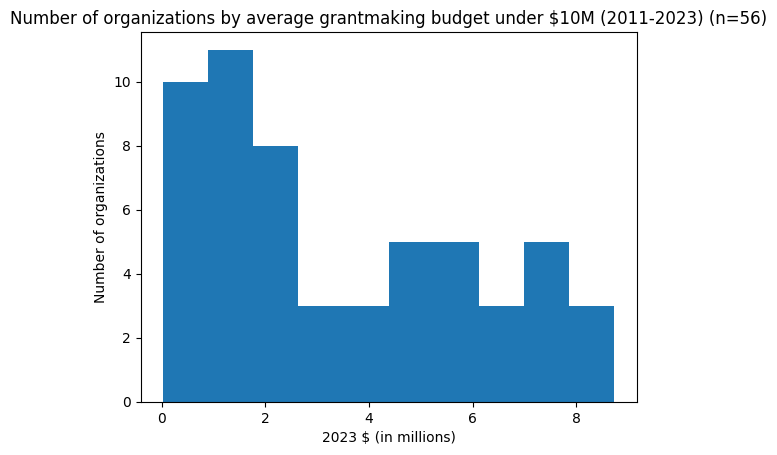

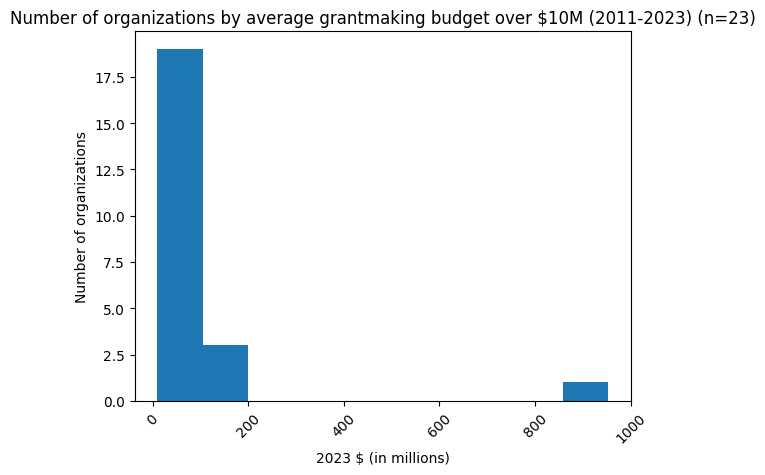

In [116]:
contributions_by_org = funder_spending_unf.groupby("name").agg({"contributions_inf":"mean"}).reset_index()
under_10m = contributions_by_org[contributions_by_org["contributions_inf"] < 10e6]
over_100m = contributions_by_org[contributions_by_org["contributions_inf"] > 10e6]

plt.hist(under_10m["contributions_inf"] / 1e6)
plt.title(f"Number of organizations by average grantmaking budget under $10M (2011-2023) (n={len(under_10m)})")
plt.xlabel("Number of organizations")
plt.ylabel("Number of organizations")
plt.ticklabel_format(style='plain')
plt.xlabel("2023 $ (in millions)")
plt.show()

plt.hist(over_100m["contributions_inf"] / 1e6)
plt.title(f"Number of organizations by average grantmaking budget over $10M (2011-2023) (n={len(over_100m)})")
plt.ylabel("Number of organizations")
plt.xticks(rotation=45)
plt.ticklabel_format(style='plain')
plt.xlabel("2023 $ (in millions)")
plt.show()

### Visualize median grant given in 2024

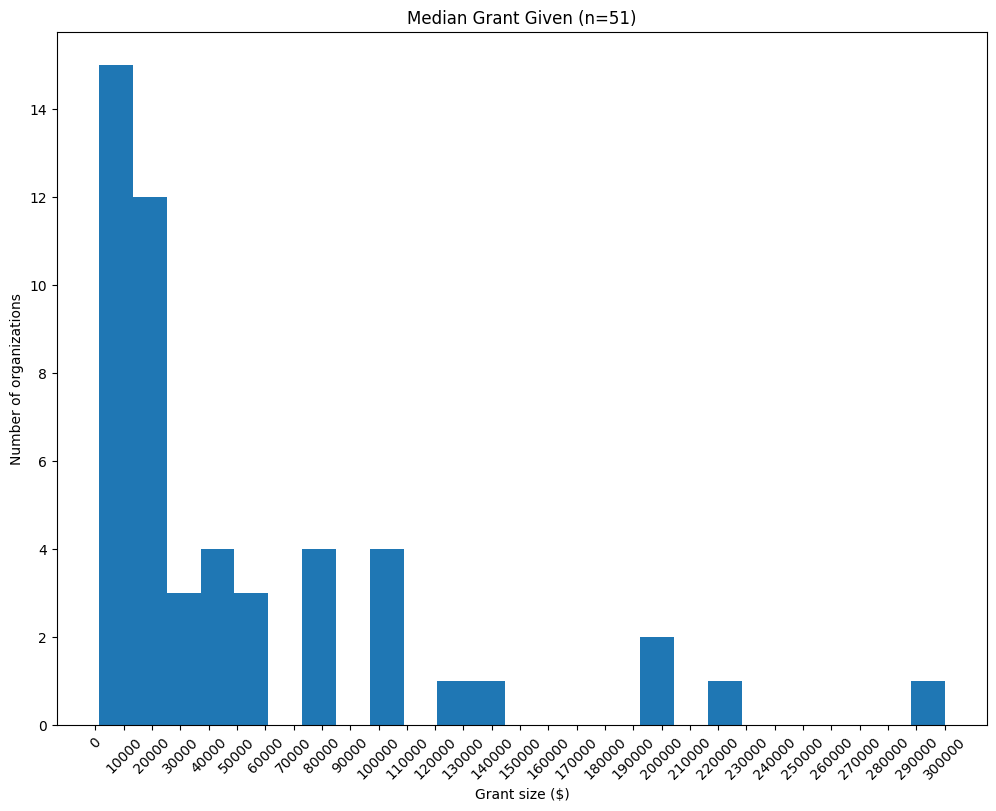

In [117]:
median_grant = funder_spending_merged.groupby("name").agg({"Median Grant Given":"first"}).reset_index()
median_grant = median_grant.drop(index=median_grant[median_grant["name"].isin(["Deutsche Bank Americas Foundation","Jerome L Greene Foundation Inc","Mizuho Usa Foundation Inc"])].index)

ax = plt.subplots(figsize=(12, 9))
plt.hist(median_grant["Median Grant Given"], bins=25)
plt.xticks(np.linspace(0,300000,31),rotation=45)
plt.title(f"Median Grant Given (n={len(median_grant)})")
plt.xlabel("Grant size ($)")
plt.ylabel("Number of organizations")
plt.show()

### Visualize total grant funding available in subsetted RSCF network funders over time

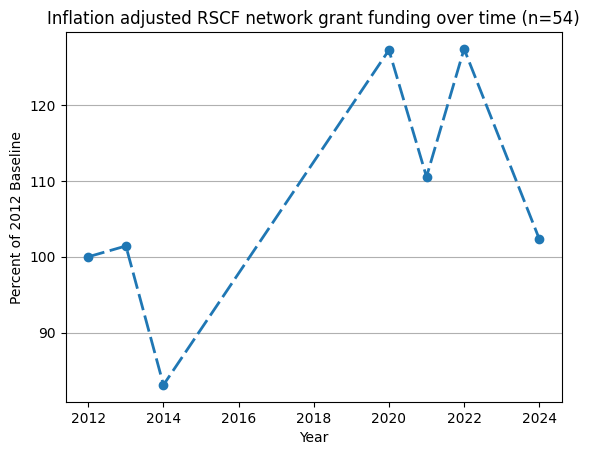

,tax_prd_yr,contributions_inf,name,norm
1,2012,4.900548e+08,54,1.000000
2,2013,4.970090e+08,54,1.014191
3,2014,4.073924e+08,54,0.831320
8,2020,6.233613e+08,54,1.272024
9,2021,5.416167e+08,54,1.105217
10,2022,6.241179e+08,54,1.273568
12,2024,5.016122e+08,54,1.023584


In [119]:
spending_by_year = funder_spending_merged.groupby(["tax_prd_yr"]).agg({"contributions_inf":"sum","name":"count"}).reset_index()
spending_by_year = spending_by_year.drop(index = spending_by_year[spending_by_year["tax_prd_yr"].isin([2011,2015,2016,2018,2019,2023])].index)
spending_by_year["norm"] = spending_by_year["contributions_inf"] / spending_by_year["contributions_inf"].iloc[0]

# plot
fig, ax = plt.subplots()
x = spending_by_year["tax_prd_yr"]
y = spending_by_year["norm"] * 100
ax.plot(x, y, linewidth=2.0,dashes=[6, 2],marker = 'o')
plt.ylabel("Percent of 2012 Baseline")
plt.xlabel("Year")
plt.grid(axis="y")
plt.title("Inflation adjusted RSCF network grant funding over time (n=54)")
plt.show()
spending_by_year

### Visualize individual or groups

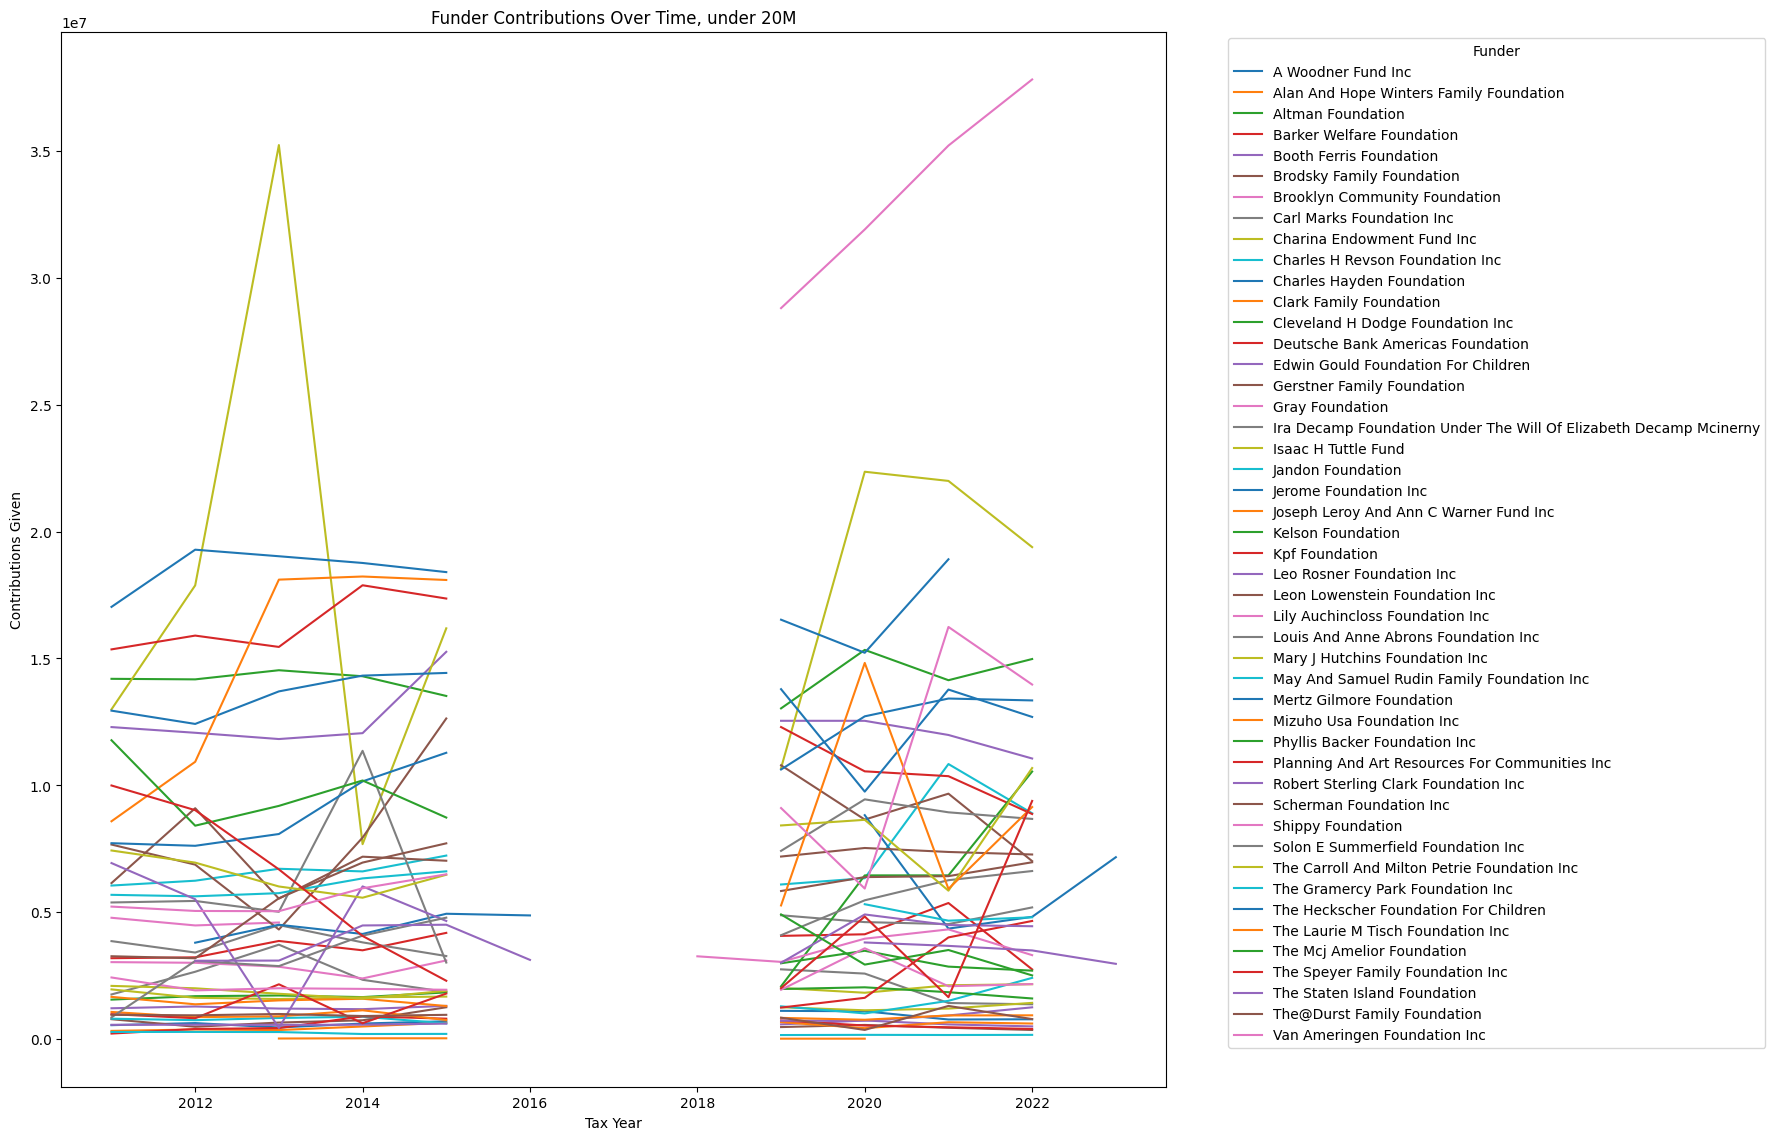

In [160]:
# Individual funder time series
# Group by funder and year
smaller = funder_spending_unf[funder_spending_unf["Contributions Given"] < 2e7]
df_grouped = smaller.groupby(["name", "tax_prd_yr"])["contributions_inf"].sum().reset_index()

# Pivot for plotting
df_pivot = df_grouped.pivot(index="tax_prd_yr", columns="name", values="contributions_inf")

# Plot
df_pivot.plot(kind="line", figsize=(18, 12))
plt.title("Funder Contributions Over Time, under 20M")
plt.xlabel("Tax Year")
plt.ylabel("Contributions Given")
plt.legend(title="Funder", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


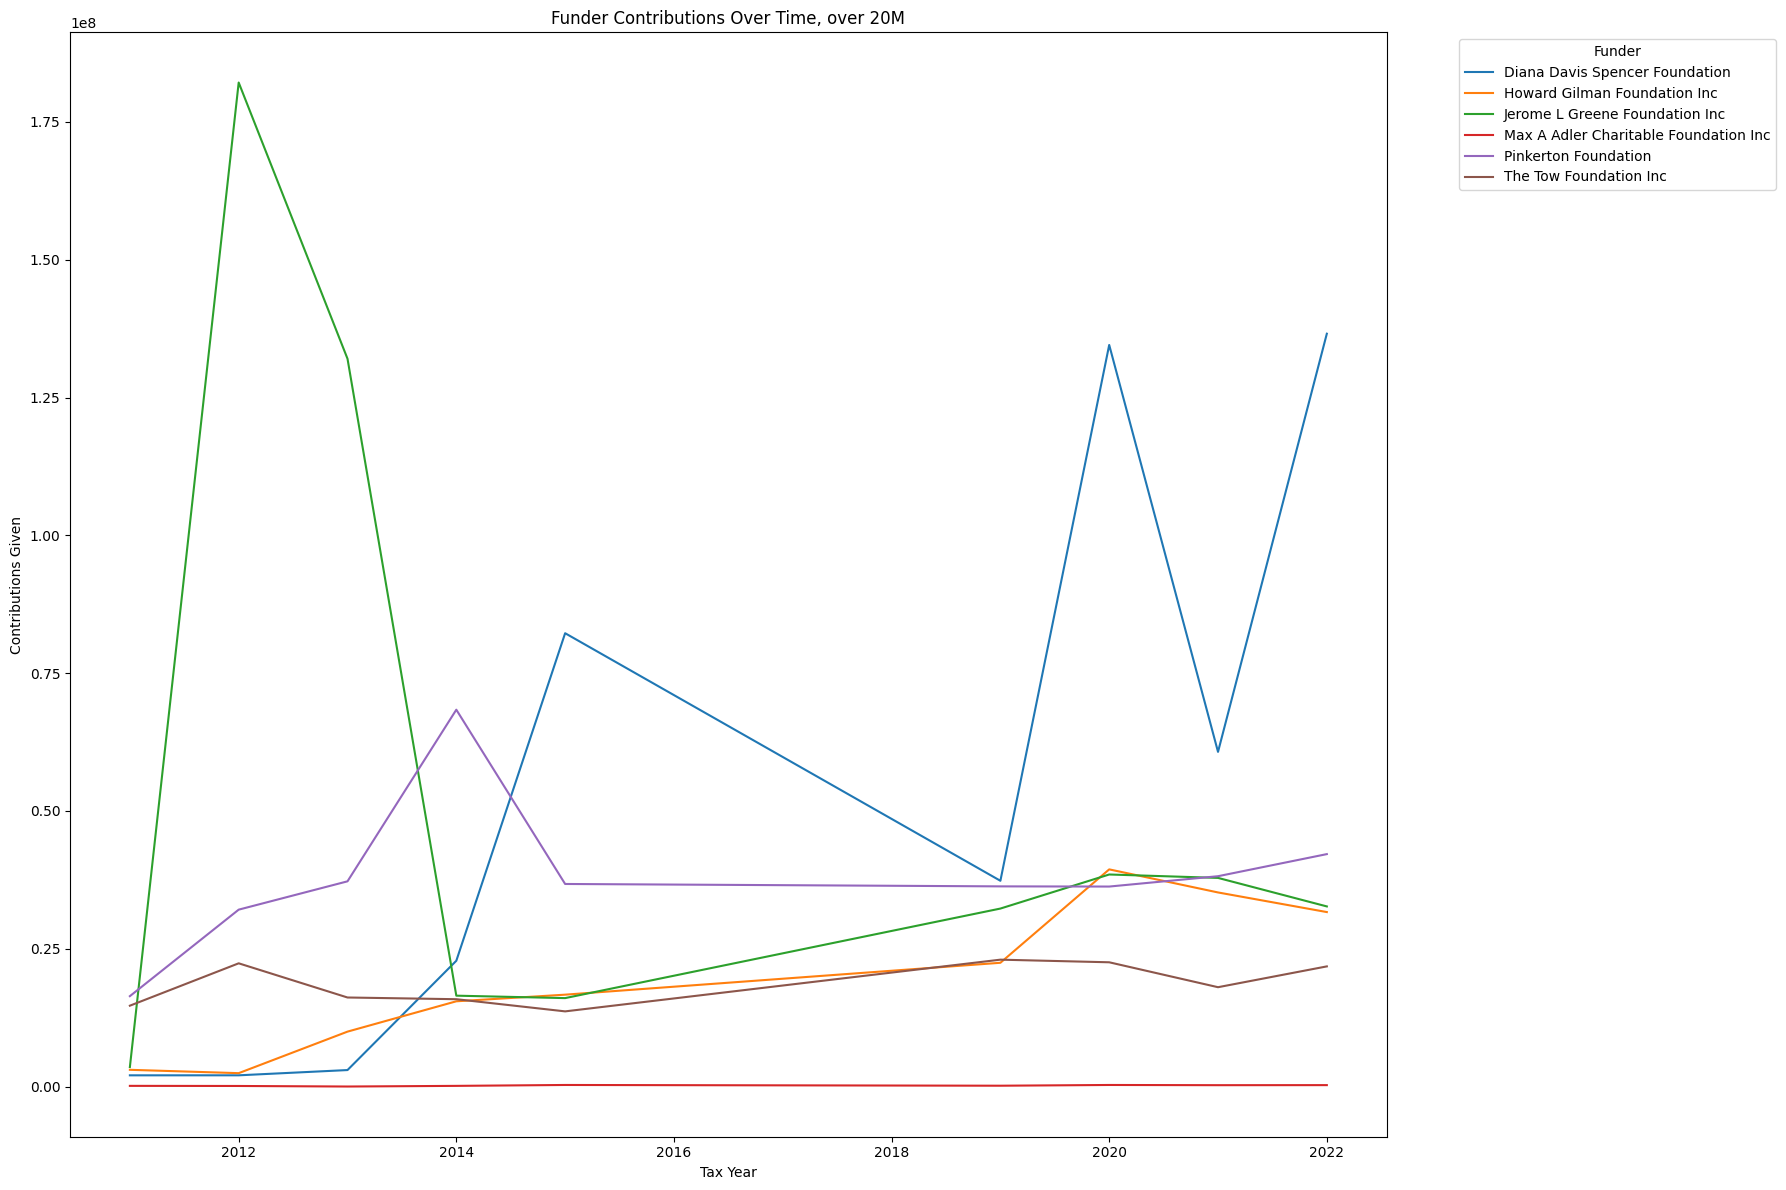

In [161]:
# Individual funder time series
# Group by funder and year
smaller = funder_spending_unf[funder_spending_unf["Contributions Given"] > 2e7]
df_grouped = smaller.groupby(["name", "tax_prd_yr"])["contributions_inf"].sum().reset_index()

# Pivot for plotting
df_pivot = df_grouped.pivot(index="tax_prd_yr", columns="name", values="contributions_inf")

# Plot
df_pivot.plot(kind="line", figsize=(18, 12))
plt.title("Funder Contributions Over Time, over 20M")
plt.xlabel("Tax Year")
plt.ylabel("Contributions Given")
plt.legend(title="Funder", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
